In [159]:
import symengine as sm
import sympy as smp
import numpy as np
from functools import cmp_to_key
from tqdm.notebook import tqdm

from utils import mv_series, compare_degrees, get_poly_dict, get_target_coeffs, get_term_name

In [160]:
def g(x):
    return sm.tanh(x)

def g_np(x):
    return np.tanh(x)

def dg(x):
    return 1 - sm.tanh(x) * sm.tanh(x)

def dg_np(x):
    return 1 - np.tanh(x) * np.tanh(x)

def ddg(x):
    return 2 * (sm.tanh(x) * sm.tanh(x) - 1) * sm.tanh(x)

In [257]:
x_dim = 3
#r_dim = 400
#r_dim = 100
r_dim = 400

In [258]:
# Symbols

x_list = [sm.Symbol(f'x_{i}') for i in range(x_dim)]
x_dot_list = [sm.Symbol('\dot{x}_' + f'{i}') for i in range(x_dim)]

x = sm.Matrix([[x_i] for x_i in x_list])
x_dot = sm.Matrix([[x_dot_i] for x_dot_i in x_dot_list])

In [273]:
A_dense_rate = 0.05
#B_scale = 0.05 # original
B_scale = 0.1
rho = 0.01 # original

#d_scale = 0.1 # ポイントアトラクタになった
d_scale = 1.0 # リミットサイクルになった
#d_scale = 2.0 # リミットサイクルになった
#d_scale = 10.0 # ポイントアトラクタになった

r_s_scale = 0.05

# Concrete values
def calc_scale_with_spectral_radius(mat, rho):
    cur_spectral_radius = max(abs(np.linalg.eigvals(mat)))
    return rho / cur_spectral_radius

rng = np.random.RandomState(0)

r_s_np = rng.uniform(low=-1, high=1, size=(r_dim, 1)) * r_s_scale

x_s_np = np.zeros((x_dim, 1))
# TODO: x_sを乱数で試す
#x_s_np = rng.uniform(low=-1.0, high=1.0, size=(x_dim, 1)) * 0.1
#x_s_np = rng.uniform(low=-1.0, high=1.0, size=(x_dim, 1)) * 1.0

B_np = (rng.uniform(low=-1.0, high=1.0, size=(r_dim, x_dim)) * B_scale)

A_np = rng.uniform(low=-1.0, high=1.0, size=(r_dim, r_dim))
sparsify = np.vectorize(lambda v: v if rng.random() < A_dense_rate else 0.0)
A_np = sparsify(A_np)

A_scale = calc_scale_with_spectral_radius(A_np, rho)
A_np = A_np * A_scale

#d_np = np.zeros((r_dim, 1))
# TODO: dを乱数で試す
d_np = rng.uniform(low=-1.0, high=1.0, size=(r_dim, 1)) * d_scale

d_s_np = A_np @ r_s_np + d_np

ArBxd_np = A_np @ r_s_np + B_np @ x_s_np + d_s_np

A_s_np = dg_np(ArBxd_np) * A_np - np.eye(r_dim)

A_s_inv_np = np.linalg.inv(A_s_np)

In [274]:
def to_sm_matrix(np_mat):
    return sm.Matrix(np_mat.tolist())

B       = to_sm_matrix(B_np)
d_s     = to_sm_matrix(d_s_np)
r_s     = to_sm_matrix(r_s_np)
A_s_inv = to_sm_matrix(A_s_inv_np)
A       = to_sm_matrix(A_np)
gamma   = 100

$$
\begin{aligned}
\boldsymbol{r}(t) + \frac{1}{\gamma} \dot{\boldsymbol{r}}
=& 
A^{*-1}
\left(\mathrm{~d} \boldsymbol{g}\left(B \boldsymbol{x}+\boldsymbol{d}^{*}\right) \circ\left(A \boldsymbol{r}^{*}\right)-\boldsymbol{g}\left(B \boldsymbol{x}+\boldsymbol{d}^{*}\right)\right)+\\
& \frac{1}{\gamma} \left(A^{*-2} + A^{*-1}\right)
\left(\left(\mathrm{~d}^{2} \boldsymbol{g}\left(B \boldsymbol{x}+\boldsymbol{d}^{*}\right) \circ\left(A \boldsymbol{r}^{*}\right)-\mathrm{d} \boldsymbol{g}\left(B \boldsymbol{x}+\boldsymbol{d}^{*}\right)\right) \circ(B \dot{\boldsymbol{x}})\right) 
\end{aligned}
$$

In [275]:
%%time

Bx_d_s = B * x + d_s

expr0 = Bx_d_s.applyfunc(dg).multiply_elementwise(A * r_s)
expr1 = Bx_d_s.applyfunc(g)
expr2 = Bx_d_s.applyfunc(ddg).multiply_elementwise(A * r_s)
expr3 = Bx_d_s.applyfunc(dg)

expr2_3 = (expr2 - expr3).multiply_elementwise(B * x_dot)

expr = A_s_inv * (expr0 - expr1) + (1 / gamma) * (A_s_inv * A_s_inv + A_s_inv) * expr2_3

x_zero = [0] * x_dim
x_dot_zero = [0] * x_dim
#x_dot_zero = [0, 0, -(8*27)/(3*20)]

# Taylor series degree
series_degree = 2

CPU times: user 16.9 s, sys: 93.6 ms, total: 17 s
Wall time: 17 s


In [276]:
%%time

# Taylor series expansion

coeff_dicts = []

pbar = tqdm(range(r_dim))

for r_index in range(r_dim):
    r_ex = mv_series(expr[r_index,0], 
                     x_list + x_dot_list, 
                     x_zero + x_dot_zero, 
                     series_degree)
                 
    # Using sympy instead of symengine for poly().
    p_c = smp.poly(r_ex)
    coeff_dicts.append(get_poly_dict(p_c, x_list + x_dot_list))
    
    pbar.update()

  0%|          | 0/400 [00:00<?, ?it/s]

CPU times: user 1min 12s, sys: 1.28 s, total: 1min 13s
Wall time: 1min 13s


In [277]:
degrees_sets = set()

for coeff_dict in coeff_dicts:
    for degrees in coeff_dict.keys():
        degrees_sets.add(degrees)

In [278]:
degrees_list = sorted(list(degrees_sets), key=cmp_to_key(compare_degrees))

In [279]:
all_coeffs = []

for coeff_dict in coeff_dicts:
    coeffs = []
    for degrees in degrees_list:
        if degrees in coeff_dict:
            coeffs.append(coeff_dict[degrees])
        else:
            coeffs.append(0)            
    all_coeffs.append(coeffs)
        
all_coeffs = np.array(all_coeffs, dtype=np.float64)

In [280]:
'''
target_coeff_dicts = [
{ # x0 + 1/gamma xdot0
    (1,0,0,0,0,0) : 1-10/gamma, # x0
    (0,1,0,0,0,0) : 10/gamma, # x1
},
{ # x1 + 1/gamma xdot1
    (1,0,0,0,0,0) : 1/gamma, # x0
    (0,1,0,0,0,0) : 1-1/gamma, # x1
    (1,0,1,0,0,0) : -20/gamma, # x0x2
},
{ # x2 + 1/gamma xdot2
    (0,0,0,0,0,0) : -(8*27) / (3*20), # 1
    (0,0,1,0,0,0) : 1-8/(3*gamma), # x2
    (1,1,0,0,0,0) : 20/gamma, # x0x1
}
]
'''

target_coeff_dicts = [
{ # x0 + 1/gamma xdot0
    (1,0,0,0,0,0) : 1-1/gamma, # x0
    (0,1,0,0,0,0) : 1/gamma, # x1
},
{ # x1 + 1/gamma xdot1
    (1,0,0,0,0,0) : 1/(gamma * 10), # x0
    (0,1,0,0,0,0) : 1-1/(gamma * 10), # x1
    (1,0,1,0,0,0) : -20/gamma, # x0x2
},
{ # x2 + 1/gamma xdot2
    (0,0,0,0,0,0) : -0.036, # 1
    (0,0,1,0,0,0) : 1-4/(15*gamma), # x2
    (1,1,0,0,0,0) : 20/gamma, # x0x1
}
]

target_coeffs = get_target_coeffs(target_coeff_dicts, degrees_list)

In [281]:
# Calc outout weight
W = (np.linalg.pinv(all_coeffs.T) @ target_coeffs.T).T

In [282]:
np.max(W)

0.7881176575009383

In [283]:
dt = 0.001

In [284]:
%%time

# Output with normal recurrent reservoir calculation

#r_rec = np.zeros((r_dim, 1))
r_rec = np.ones((r_dim, 1)) * 0.01
x_ = np.ones((3,1)) * 0.1

y_recs = []

steps = 100000

pbar = tqdm(range(steps))

for i in range(steps):
    dr = (-r_rec + g_np(A_np @ r_rec + (B_np @ x_).reshape(-1,1) + d_np)) * gamma * dt
    # Euler method
    r_rec += dr
    y_rec = W @ r_rec
    x_ = y_rec    
    y_recs.append(y_rec)
    
    pbar.update()
    
y_recs = np.array(y_recs).reshape((-1,3))    

  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: user 51.6 s, sys: 3.72 s, total: 55.3 s
Wall time: 5.92 s


In [285]:
import matplotlib.pyplot as plt
%matplotlib inline

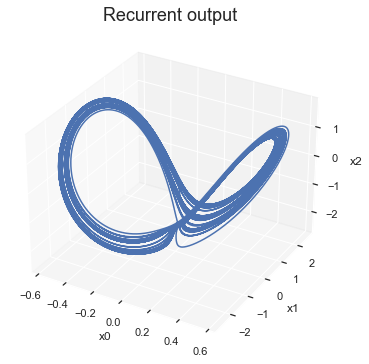

In [286]:
fig = plt.figure(figsize=(6,6))

plt.rcParams['axes.facecolor'] = 'white'

ax = fig.add_subplot(111, projection='3d')

ax.set_title('Recurrent output', fontsize=18)

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")

ax.plot(y_recs[:,0], 
        y_recs[:,1], 
        y_recs[:,2])

plt.show()

In [287]:
y_recs

array([[ 0.01295103,  0.0454534 , -0.08247888],
       [ 0.01290884,  0.04606196, -0.08638248],
       [ 0.01287492,  0.04661384, -0.09025244],
       ...,
       [ 0.54942426,  1.20648085,  1.54804196],
       [ 0.54963605,  1.18960635,  1.55568197],
       [ 0.54983223,  1.17264853,  1.56314974]])

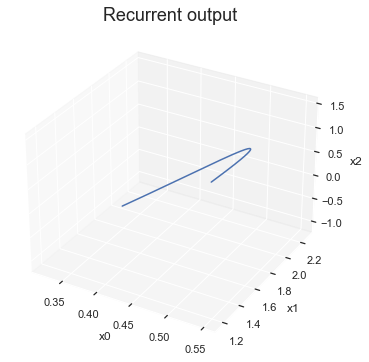

In [288]:
fig = plt.figure(figsize=(6,6))

plt.rcParams['axes.facecolor'] = 'white'

ax = fig.add_subplot(111, projection='3d')

ax.set_title('Recurrent output', fontsize=18)

ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("x2")

ax.plot(y_recs[-200:,0], 
        y_recs[-200:,1], 
        y_recs[-200:,2])

plt.show()

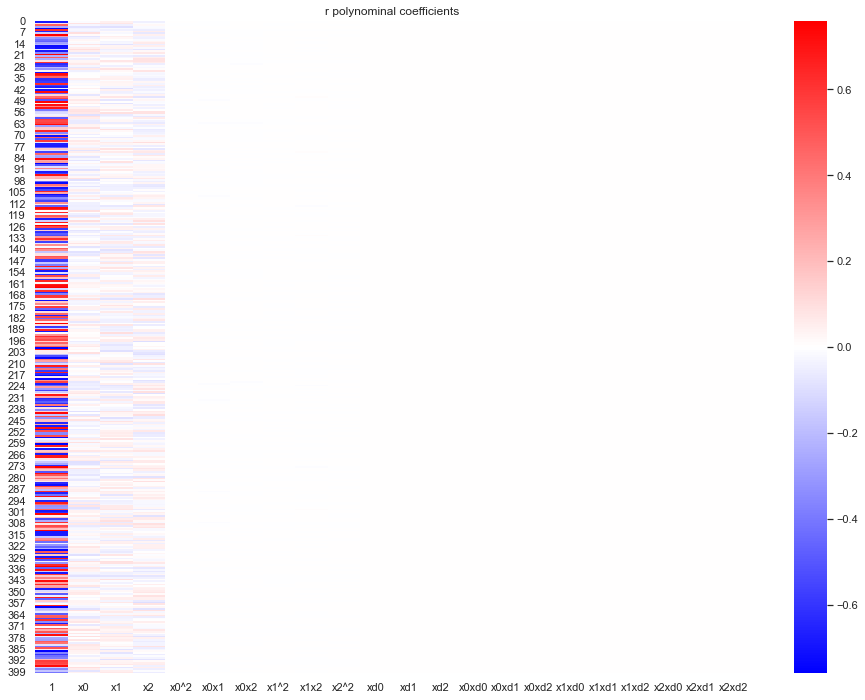

In [289]:
import seaborn as sns

xticklabels=[get_term_name(degrees) for degrees in degrees_list]
     
sns.set(rc = {'figure.figsize':(16,12)})    

plt.title('r polynominal coefficients')
sns.heatmap(all_coeffs, cmap='bwr', xticklabels=xticklabels)
plt.show()

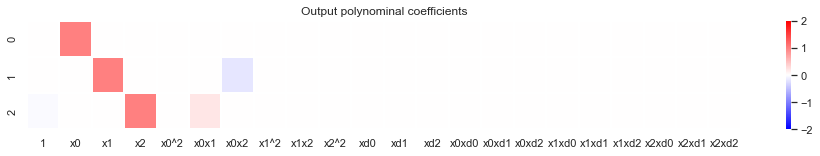

In [290]:
sns.set(rc = {'figure.figsize':(16,2)})

plt.title('Output polynominal coefficients')
sns.heatmap(target_coeffs, cmap='bwr', linewidths=0.005, vmin=-2, vmax=2,
            xticklabels=xticklabels)
plt.show()

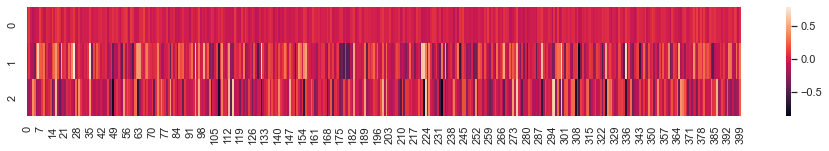

In [291]:
sns.heatmap(W)
plt.show()